In [1]:
from dataset import SFMNNDataset
from network import SFMNNEncoder
from simulate import SFMNNSimulation
from loss import SFMNNLoss
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
from dotenv import load_dotenv
import logging
import numpy as np

/home/omirako/.local/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
load_dotenv()
data_folder = os.getenv("DATA_FOLDER")

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s",
                    handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

with open(data_folder + "simulation_sim_0_amb_0.json") as f:
    data = json.load(f)
with open(data_folder + "simulation_lookuptable.json") as f:
    lookup = json.load(f)

# Load the dataset
dataset = SFMNNDataset(data_folder + 'simulation_lookuptable.json', 'output/', patch_size=5)

# Load the dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)


2025-03-21 17:41:44,441 [INFO] Using 3620 wavelength channels.
2025-03-21 17:41:44,443 [INFO] Found 1350 simulation JSON files.
Loading JSON files:   0%|          | 0/1350 [00:00<?, ?it/s]

Loading JSON files: 100%|██████████| 1350/1350 [00:16<00:00, 84.10it/s]
2025-03-21 17:42:00,873 [INFO] Fixed Esun computed as: 268.4315
2025-03-21 17:42:00,955 [INFO] Total simulations loaded: 1350
2025-03-21 17:42:00,955 [INFO] Total patches loaded: 60


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Number of spectral bands
n_spectral_bands = len(dataset.get_wl())
n_spectral_bands

3620

In [5]:
C,H,W = dataset[0].shape
H, W, C

(5, 5, 3623)

In [ ]:
# Initialize the network
encoder = SFMNNEncoder(input_channels=C,num_variables = 9 ,latent_dim=C).to(device)

print(encoder)

SFMNNEncoder(
  (input_norm): BatchNorm1d(3623, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=3623, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=4096, out_features=8192, bias=True)
    (5): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=8192, out_features=16384, bias=True)
    (9): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=16384, out_features=16384, bias=True)
    (12): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (latent_proj): Linear(in_features=16384, out_features=32607, bias=True)
)


In [7]:
optimizer = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=0.0001)
criterion = SFMNNLoss(torch.tensor(n_spectral_bands))

In [8]:
# test the network
for i, data in enumerate(dataloader):
    data = data.to(device)
    print('input:', data.shape)
    out = encoder(data)
    print('output:', out.shape)

input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
output: torch.Size([3, 5, 5, 9, 3623])
input: torch.Size([3, 3623, 5, 5])
out

In [9]:
torch.tensor(dataset.get_wl()).shape

torch.Size([3620])

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F_func

class FourStreamSimulator(nn.Module):
    def __init__(self, spectral_window=(750, 770), high_res=0.0055):
        super().__init__()
        self.register_buffer('lambda_hr', torch.arange(*spectral_window, high_res))
        self.mu_f = 737.0  # Fluorescence peak wavelength

    def forward(self, t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s):
        # Compute product terms.
        t7 = t3 * t4
        t8 = t3 * t6
        t9 = t4 * t5
        t10 = t4 * t2
        t11 = t3 * t2
        # Simulation equation.
        LTOA = t1 * t2 + (t1 * t8 * R + t9 * R + t10 * R + t11 * R + t6 * F + t7 * F) / (1 - t3 * R)
        # Ensure cos_theta_s has shape [B, 1, H, W]
        if cos_theta_s.dim() == 3:
            cos_theta_s = cos_theta_s.unsqueeze(1)
        mod_factor = (E_s * cos_theta_s) / np.pi
        LTOA_mod = LTOA * mod_factor
        logger.debug(f"FourStreamSimulator: mod_factor min {mod_factor.min().item():.4f}, max {mod_factor.max().item():.4f}")
        return LTOA_mod

import torch
import torch.nn as nn
import torch.nn.functional as F_func

class HyPlantSensorSimulator(nn.Module):
    def __init__(self, sensor_wavelengths, high_res=0.0055):
        super().__init__()
        self.register_buffer('sensor_wavelengths', sensor_wavelengths)
        self.high_res = high_res
        self.register_buffer('wl_range', torch.tensor([
            sensor_wavelengths.min(),
            sensor_wavelengths.max()
        ]))

    def forward(self, L_hr, delta_lambda, delta_sigma):
        # L_hr: [B, C_hr, H, W]
        B, C_hr, H, W = L_hr.shape
        
        #######################
        # 1) Gaussian Blur
        #######################
        sigma = (0.27 + delta_sigma) * 2.3548  # FWHM -> std
        kernel_size = max(3, int(6 * sigma / self.high_res))
        x = torch.linspace(-3*sigma, 3*sigma, kernel_size, device=L_hr.device)
        kernel = torch.exp(-0.5 * (x / sigma) ** 2)
        kernel /= kernel.sum()

        # shape: [B*H*W, 1, C_hr]
        L_hr_reshaped = L_hr.permute(0, 2, 3, 1).reshape(B*H*W, 1, C_hr)
        L_blur = F_func.conv1d(L_hr_reshaped, kernel.view(1, 1, -1),
                               padding=kernel_size // 2)
        new_C_hr = L_blur.shape[-1]
        # reshape to [B, H, W, new_C_hr] -> [B, new_C_hr, H, W]
        L_blur = L_blur.view(B, H, W, new_C_hr).permute(0, 3, 1, 2)

        # --- Debug: see if L_blur is constant across channel dimension
        if B == 1:
            print("L_blur (per batch) min/max:",
                  L_blur.min().item(), L_blur.max().item())
            # Also check std along channel dimension:
            std_channels = L_blur.std(dim=1)  # shape [B, H, W]
            print("Mean channel-std:", std_channels.mean().item())

        #######################
        # 2) Wavelength Shifts
        #######################
        # Delta-lambda average for each batch item
        avg_delta = delta_lambda.mean(dim=(1,2)).view(B, 1)  # shape [B, 1]
        
        # shift sensor wavelengths by avg_delta: shape [B, #_sensor_bands]
        shifted_wl = self.sensor_wavelengths.unsqueeze(0) + avg_delta
        # normalize to [-1,1]
        wl_min, wl_max = self.wl_range[0].item(), self.wl_range[1].item()
        normalized_wl = 2 * (shifted_wl - wl_min) / (wl_max - wl_min) - 1
        
        # --- Debug: check that normalized_wl is not all the same or out of bounds
        if B == 1:
            print("normalized_wl min/max:",
                  normalized_wl.min().item(), normalized_wl.max().item())

        #######################
        # 3) grid_sample setup
        #######################
        # L_blur shape is [B, new_C_hr, H, W], interpret new_C_hr as "height"
        # reshape to [B*H*W, 1, new_C_hr, 1]
        L_blur_2d = L_blur.permute(0, 2, 3, 1).reshape(
            B*H*W, 1, new_C_hr, 1
        )

        # Make grid: shape [N, out_H, out_W, 2]
        num_sensor = self.sensor_wavelengths.shape[0]  # e.g. 172

        # Expand normalized_wl from [B, num_sensor] to [B, H*W, num_sensor]
        normalized_wl_expanded = normalized_wl.unsqueeze(1).expand(
            B, H*W, num_sensor
        )
        # Reshape to [B*H*W, 1, num_sensor]
        normalized_wl_expanded = normalized_wl_expanded.reshape(
            B*H*W, 1, num_sensor
        )

        grid_y = normalized_wl_expanded  # treat as "height" coords in [-1,1]
        grid_x = torch.zeros_like(grid_y) # x=0
        grid = torch.stack((grid_y, grid_x), dim=-1)  # [B*H*W, 1, num_sensor, 2]

        # --- Debug
        if B == 1:
            print("grid y-range: [", grid_y.min().item(), ",",
                  grid_y.max().item(), "]")

        #######################
        # 4) grid_sample
        #######################
        L_sampled = F_func.grid_sample(
            L_blur_2d, grid, mode='bilinear', align_corners=True
        )
        # L_sampled shape: [B*H*W, 1, 1, num_sensor]
        L_sampled = L_sampled.view(B, H, W, num_sensor).permute(0, 3, 1, 2)

        # Debug final shape
        if B == 1:
            print("L_sampled shape:", L_sampled.shape,
                  "  min/max:", L_sampled.min().item(), L_sampled.max().item())

        return L_sampled


class SFMNNSimulation(nn.Module):
    def __init__(self, sensor_wavelengths):
        super().__init__()
        self.four_stream = FourStreamSimulator()
        self.sensor_sim = HyPlantSensorSimulator(sensor_wavelengths)

    def forward(self, t1, t2, t3, t4, t5, t6, R, F, delta_lambda, delta_sigma, E_s, cos_theta_s):
        L_hr = self.four_stream(t1, t2, t3, t4, t5, t6, R, F, E_s, cos_theta_s)
        L_hyp = self.sensor_sim(L_hr, delta_lambda, delta_sigma)
        return L_hyp

In [18]:
class SFMNNLoss(nn.Module):
    def __init__(self, gamma_f=5, gamma_N=10, gamma_a=1, ndvi_threshold=0.15, red_idx=680, nir_idx=800):
        super().__init__()
        self.gamma_f = gamma_f
        self.gamma_N = gamma_N
        self.gamma_a = gamma_a
        self.ndvi_threshold = ndvi_threshold
        self.red_idx = red_idx
        self.nir_idx = nir_idx

    def forward(self, pred, target, outputs, E_s, cos_theta_s, loss_indices):
        # pred and target are already windowed (shape: [B, window_size, H, W])
        recon_loss = torch.mean((pred - target) ** 2)
        
        # NDVI loss computed from full reflectance (not windowed)
        red = outputs['reflectance'][:, self.red_idx]
        nir = outputs['reflectance'][:, self.nir_idx]
        ndvi = (nir - red) / (nir + red + 1e-6)
        ndvi_loss = torch.mean(outputs['sif'] * ((ndvi <= self.ndvi_threshold).float()))
        
        w_f = self.compute_w_f(target, outputs['sif'])
        signal_loss = torch.mean((pred - target) ** 2 * w_f.view(1, -1, 1, 1))
        
        # Extract window from reflectance and E_s
        R_window = outputs['reflectance'][:, loss_indices, :, :]
        R_mean = R_window.mean(dim=(2,3), keepdim=True)
        L_atm_R = pred - outputs['sif'].unsqueeze(1)
        B = E_s.size(0)
        E_s_const = E_s.mean(dim=(2,3), keepdim=True)  # [B, n_spectral_bands, 1, 1]
        E_s_window = E_s_const[:, loss_indices, :, :]
        cos_theta_s_const = cos_theta_s.mean(dim=(1,2), keepdim=True).view(B, 1, 1, 1)
        denom = E_s_window * cos_theta_s_const + 1e-6
        t_tot = (L_atm_R * R_mean) / denom
        atm_loss = torch.mean(torch.relu(t_tot - 1))
        
        total_loss = recon_loss  # regularizers not added for now
        
        loss_dict = {
            'total': total_loss,
            'recon': recon_loss,
            'signal': signal_loss,
            'ndvi': ndvi_loss,
            'atm': atm_loss
        }
        return total_loss, loss_dict

    def compute_w_f(self, L_HyP, sif_pred, epsilon=1e-6):
        f_sq = sif_pred.unsqueeze(1) ** 2
        sum_f_sq = torch.mean(f_sq, dim=(0, 2, 3))
        sigma_L2 = torch.var(L_HyP, dim=(0, 2, 3), unbiased=False)
        numerator = sum_f_sq
        denominator = sum_f_sq / (sigma_L2 + epsilon)
        w_f = (1.0 / (sigma_L2 + epsilon)) * (numerator / (denominator.sum() + epsilon))
        return w_f

In [23]:
import numpy as np

def train_model(encoder):
    from dotenv import load_dotenv
    load_dotenv()
    data_folder = os.getenv("DATA_FOLDER")
    lookup_table_path = os.path.join(data_folder, 'simulation_lookuptable.json')
    #dataset = SFMNNDataset(lookup_table_path, data_folder, patch_size=5)
    #dataloader = DataLoader(dataset, batch_size=3, shuffle=True, drop_last=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    n_spectral_bands = len(dataset.get_wl())
    # Input channels: n_spectral_bands + 3
    C = n_spectral_bands + 3
    logger.info(f"Spectral channels: {n_spectral_bands}, total input channels: {C}")

    optimizer = optim.Adam(encoder.parameters(), lr=1e-4)
    # Pass the loss indices later.
    loss_fn = SFMNNLoss(red_idx=680, nir_idx=800).to(device)

    sensor_wl = torch.tensor(dataset.get_wl(), dtype=torch.float, device=device)
    simulation = SFMNNSimulation(sensor_wl).to(device)

    fixed_esun = dataset.fixed_esun
    logger.info(f"Using fixed Esun: {fixed_esun:.4f}")

    num_epochs = 30
    # Define spectral window indices for loss: e.g., wavelengths between 760 and 780 nm.
    indices = ((sensor_wl >= 760.0) & (sensor_wl <= 780.0)).nonzero(as_tuple=True)[0]
    logger.info(f"Loss calculated over indices: {indices.tolist()}, corresponding to {sensor_wl[indices[0]].item():.1f}-{sensor_wl[indices[-1]].item():.1f} nm.")

    for epoch in range(num_epochs):
        encoder.train()
        epoch_loss = 0.0
        num_samples = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch in pbar:
            # batch: [B, 3623, H, W]
            batch = batch.to(device)
            B, _, H, W = batch.shape
            
            n_spectral_bands = len(dataset.get_wl())  # should be 3620

            # Extract target reflectance: first n_spectral_bands channels.
            target_full = batch[:, :n_spectral_bands, :, :]
            target = target_full[:, indices, :, :]

            # Extra channels: channel order: 0..n_spectral_bands-1: LTOA, n_spectral_bands: XTE, n_spectral_bands+1: SZA, n_spectral_bands+2: GNDALT.
            sza = batch[:, n_spectral_bands+1, :, :]
            E_s = fixed_esun * torch.ones(B, n_spectral_bands, H, W, device=device)
            cos_theta_s = torch.cos(sza * np.pi / 180.0)

            latent = encoder(batch)  # Expected shape: [B, H, W, 9, latent_dim]
            # Force latent to only have the first n_spectral_bands channels
            latent = latent[:, :, :, :, :n_spectral_bands]

            t1 = latent[:, :, :, 0, :].permute(0, 3, 1, 2)  # Now shape [B, 3620, H, W]
            t2 = latent[:, :, :, 1, :].permute(0, 3, 1, 2)
            t3 = latent[:, :, :, 2, :].permute(0, 3, 1, 2)
            t4 = latent[:, :, :, 3, :].permute(0, 3, 1, 2)
            t5 = latent[:, :, :, 4, :].permute(0, 3, 1, 2)
            t6 = latent[:, :, :, 5, :].permute(0, 3, 1, 2)
            R_param = latent[:, :, :, 6, :].permute(0, 3, 1, 2)
            F_param = latent[:, :, :, 7, :].permute(0, 3, 1, 2)
            delta_lambda_enc = latent[:, :, :, 8, :].permute(0, 3, 1, 2)
            delta_lambda = delta_lambda_enc.mean(dim=1)  # [B, H, W]

            # Use a realistic delta_sigma (set to 0.0 here to preserve spectral resolution).
            sim_output_full = simulation(t1, t2, t3, t4, t5, t6, R_param, F_param,
                                          delta_lambda, torch.tensor(0.0, device=device),
                                          E_s, cos_theta_s)
            # sim_output_full: [B, 3620, H, W]
            pred = sim_output_full[:, indices, :, :]

            # Predicted SIF from F_param.
            predicted_sif = F_param.mean(dim=1)  # [B, H, W]
            outputs_dict = {
                'reflectance': sim_output_full,
                'sif': predicted_sif
            }

            total_loss, loss_dict = loss_fn(pred, target, outputs_dict, E_s, cos_theta_s, indices)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * B
            num_samples += B

            pbar.set_postfix({
                "loss": total_loss.item(),
                "recon": loss_dict['recon'].item(),
                "signal": loss_dict['signal'].item(),
                "ndvi": loss_dict['ndvi'].item(),
                "atm": loss_dict['atm'].item()
            })
        avg_epoch_loss = epoch_loss / num_samples
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_epoch_loss:.4f}")
        
    return encoder

if __name__ == "__main__":
    encoder = train_model(encoder)

2025-03-21 17:50:18,592 [INFO] Using device: cuda
2025-03-21 17:50:18,592 [INFO] Spectral channels: 3620, total input channels: 3623
2025-03-21 17:50:18,593 [INFO] Using fixed Esun: 268.4315
2025-03-21 17:50:18,594 [INFO] Loss calculated over indices: [2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 235

Epoch 1/30 - Avg Loss: 4263192.4020


Epoch 2/30 - Avg Loss: 164417838.1523


Epoch 3/30 - Avg Loss: 2254568.7553


Epoch 4/30 - Avg Loss: 14452331.8318


Epoch 5/30 - Avg Loss: 332317.0939


Epoch 6/30 - Avg Loss: 7452364.1333


Epoch 7/30 - Avg Loss: 153267.6890


Epoch 8/30 - Avg Loss: 15888609.9002


Epoch 9/30 - Avg Loss: 467755.2374


Epoch 10/30 - Avg Loss: 256295.8321


Epoch 11/30 - Avg Loss: 93611.8876


Epoch 12/30 - Avg Loss: 79546.1223


Epoch 13/30 - Avg Loss: 92048.0127


Epoch 14/30 - Avg Loss: 38077.2171


Epoch 15/30 - Avg Loss: 16343618.4912


Epoch 16/30 - Avg Loss: 184748.0367


Epoch 17/30 - Avg Loss: 583105.2833


Epoch 18/30 - Avg Loss: 1044554.3864


Epoch 19/30 - Avg Loss: 574351.7322


Epoch 20/30 - Avg Loss: 12289098.3717


Epoch 21/30 - Avg Loss: 219976787.2022


Epoch 22/30 - Avg Loss: 26879667.6625


Epoch 23/30 - Avg Loss: 204871.3800


Epoch 24/30 - Avg Loss: 5175601.8417


Epoch 25/30 - Avg Loss: 307976.5877


Epoch 26/30 - Avg Loss: 17021473.8237


Epoch 27/30 - Avg Loss: 815097.2580


Epoch 28/30 - Avg Loss: 116065.2447


Epoch 29/30 - Avg Loss: 445759.0327


Epoch 30/30 - Avg Loss: 53707.2610


In [20]:
sample = dataset[0].unsqueeze(0).to(device)
sample

tensor([[[[ 5.4591, 10.5580,  6.0325, 31.8378,  7.5234],
          [ 8.5876, 10.6005,  5.8855, 13.0000,  5.4552],
          [ 4.0683, 12.8006, 12.7294, 23.9573,  4.8054],
          [ 6.9462,  4.3470,  6.7002, 21.1743, 12.7579],
          [ 4.5508, 32.5957, 21.0902, 17.3496,  7.5539]],

         [[ 4.8513,  9.3802,  5.3862, 28.3325,  6.6825],
          [ 7.6612,  9.4229,  5.2383, 11.5801,  4.8560],
          [ 3.6427, 11.3793, 11.3077, 21.3023,  4.2980],
          [ 6.1863,  3.8734,  5.9525, 18.8350, 11.3363],
          [ 4.0417, 28.9670, 18.7504, 15.4657,  6.7132]],

         [[ 5.3975, 10.4364,  5.9722, 31.5008,  7.4368],
          [ 8.4989, 10.4794,  5.8230, 12.8625,  5.3982],
          [ 4.0297, 12.6602, 12.5879, 23.6975,  4.7582],
          [ 6.8713,  4.3008,  6.6254, 20.9347, 12.6168],
          [ 4.4998, 32.2392, 20.8494, 17.1670,  7.4677]],

         ...,

         [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          

L_blur (per batch) min/max: -825.0157470703125 1776.151123046875
Mean channel-std: 68.93120574951172
normalized_wl min/max: -1.0000659227371216 0.9999340772628784
grid y-range: [ -1.0000659227371216 , 0.9999340772628784 ]
L_sampled shape: torch.Size([1, 3620, 5, 5])   min/max: -116.35869598388672 271.19830322265625


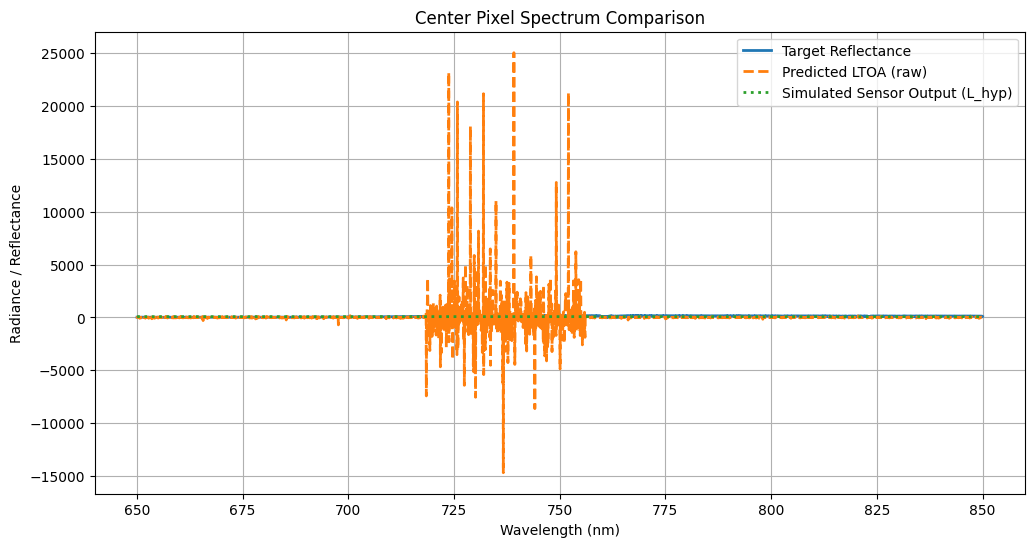

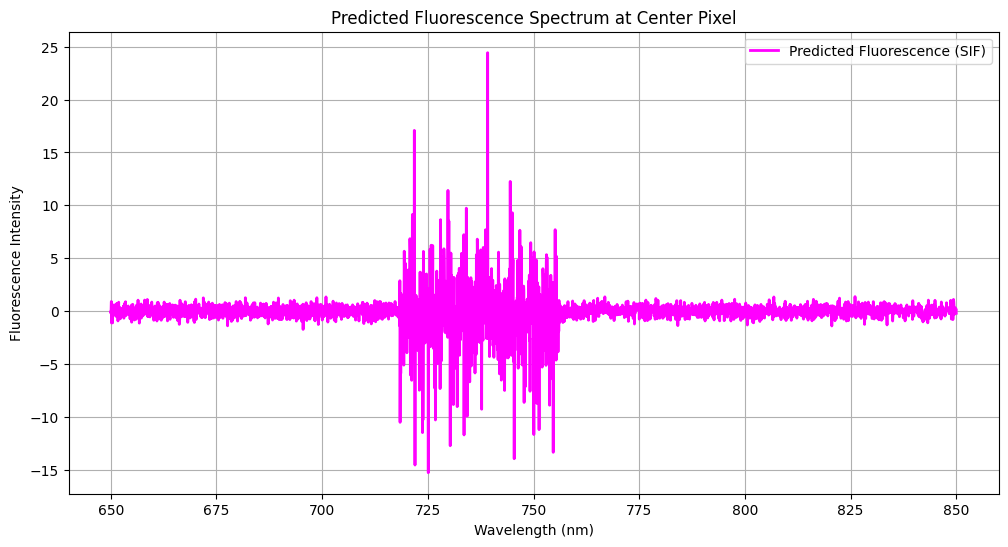

Center Pixel Target Reflectance: [ 24.03323   21.37882   23.774633 ... 124.285545 107.228745  92.352264]
Center Pixel Raw LTOA: [-71.33632    6.153336 -10.269966 ...   3.477817  20.842546  14.764841]
Center Pixel Simulated L_hyp: [76.925766 76.925766 76.925766 ... 76.925766 76.925766 76.925766]
Center Pixel Predicted SIF Spectrum: [-0.08366318 -0.21225576  0.31403914 ... -0.03917436  0.22557652
 -0.20201664]


In [24]:
import matplotlib.pyplot as plt
import random

def verify_inference(encoder, simulation, dataset, fixed_esun, sensor_wl, device):
    """
    Randomly selects a patch from the dataset, performs inference,
    and plots:
      - The original target reflectance spectrum (from the patch)
      - The simulated sensor output L_hyp spectrum (after sensor simulation)
      - The raw predicted LTOA spectrum (before sensor simulation)
      - The predicted fluorescence (SIF) spectral signature (without averaging)
    
    Assumes:
      - The dataset returns a tensor of shape [C, H, W] with C = num_wavelengths + 3,
        where the first num_wavelengths channels are LTOA.
      - sensor_wl is a tensor of shape [num_wavelengths].
      - The extra channels are (in order): XTE, SZA, GNDALT.
    """
    encoder.eval()
    simulation.eval()
    
    # Randomly select one patch from the dataset.
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx].unsqueeze(0).to(device)  # shape: [1, C, H, W]
    B, C, H, W = sample.shape
    n_spectral = len(dataset.get_wl())  # e.g., 3620
    
    # Extract target reflectance from the first n_spectral channels.
    target_full = sample[:, :n_spectral, :, :]  # shape: [1, n_spectral, H, W]
    
    # Extract extra channels.
    # Channel order: [0:n_spectral] = LTOA, [n_spectral] = XTE, [n_spectral+1] = SZA, [n_spectral+2] = GNDALT.
    sza = sample[:, n_spectral + 1, :, :]  # shape: [1, H, W]
    # Create E_s from fixed_esun with shape [1, n_spectral, H, W]
    E_s = fixed_esun * torch.ones(1, n_spectral, H, W, device=device)
    cos_theta_s = torch.cos(sza * np.pi / 180.0)  # shape: [1, H, W]
    
    with torch.no_grad():
        latent = encoder(sample)  # expected shape: [1, H, W, 9, latent_dim]
        # Force latent to only have the spectral channels:
        latent = latent[:, :, :, :, :n_spectral]  # Now shape: [1, H, W, 9, n_spectral]
        
        # Extract latent variables; each becomes shape: [1, n_spectral, H, W]
        t1 = latent[:, :, :, 0, :].permute(0, 3, 1, 2)
        t2 = latent[:, :, :, 1, :].permute(0, 3, 1, 2)
        t3 = latent[:, :, :, 2, :].permute(0, 3, 1, 2)
        t4 = latent[:, :, :, 3, :].permute(0, 3, 1, 2)
        t5 = latent[:, :, :, 4, :].permute(0, 3, 1, 2)
        t6 = latent[:, :, :, 5, :].permute(0, 3, 1, 2)
        R_param = latent[:, :, :, 6, :].permute(0, 3, 1, 2)
        F_param = latent[:, :, :, 7, :].permute(0, 3, 1, 2)  # Full spectral fluorescence prediction.
        delta_lambda_enc = latent[:, :, :, 8, :].permute(0, 3, 1, 2)
        delta_lambda = delta_lambda_enc.mean(dim=1)  # [1, H, W]
        
        delta_sigma = torch.tensor(0.0, device=device)
        
        # Compute simulated sensor output L_hyp (after sensor simulation).
        L_hyp = simulation(t1, t2, t3, t4, t5, t6, R_param, F_param,
                           delta_lambda, delta_sigma, E_s, cos_theta_s)
        # L_hyp: [1, n_spectral, H, W]
        
        # Also compute the raw predicted LTOA (before sensor simulation) by calling the four_stream module directly.
        L_toa = simulation.four_stream(t1, t2, t3, t4, t5, t6, R_param, F_param, E_s, cos_theta_s)
        # L_toa: [1, n_spectral, H, W]
        
        # Instead of averaging F_param to a single value, we keep it as full-spectrum.
        predicted_sif = F_param  # [1, n_spectral, H, W]
    
    # For plotting, select the center pixel of the patch.
    center_h, center_w = H // 2, W // 2
    # Get spectra from the center pixel:
    target_spec = target_full[0, :, center_h, center_w].cpu().numpy()  # ground truth reflectance
    L_hyp_spec = L_hyp[0, :, center_h, center_w].cpu().numpy()         # sensor simulated LTOA (L_hyp)
    L_toa_spec = L_toa[0, :, center_h, center_w].cpu().numpy()           # raw LTOA before sensor simulation
    predicted_sif_spec = predicted_sif[0, :, center_h, center_w].cpu().numpy()  # full fluorescence spectrum
    
    # Plot the target reflectance vs. simulated sensor output vs. raw LTOA.
    plt.figure(figsize=(12, 6))
    plt.plot(sensor_wl.cpu().numpy(), target_spec, label='Target Reflectance', linewidth=2)
    plt.plot(sensor_wl.cpu().numpy(), L_toa_spec, label='Predicted LTOA (raw)', linestyle='--', linewidth=2)
    plt.plot(sensor_wl.cpu().numpy(), L_hyp_spec, label='Simulated Sensor Output (L_hyp)', linestyle=':', linewidth=2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Radiance / Reflectance')
    plt.title('Center Pixel Spectrum Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the predicted fluorescence spectrum (SIF) at the center pixel.
    plt.figure(figsize=(12, 6))
    plt.plot(sensor_wl.cpu().numpy(), predicted_sif_spec, label='Predicted Fluorescence (SIF)', color='magenta', linewidth=2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fluorescence Intensity')
    plt.title('Predicted Fluorescence Spectrum at Center Pixel')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("Center Pixel Target Reflectance:", target_spec)
    print("Center Pixel Raw LTOA:", L_toa_spec)
    print("Center Pixel Simulated L_hyp:", L_hyp_spec)
    print("Center Pixel Predicted SIF Spectrum:", predicted_sif_spec)


# To run verification after training:
# Assume encoder, simulation, dataset, fixed_esun, sensor_wl, device are defined as in train_model().
# For example, after training, call:
sensor_wl = torch.tensor(dataset.get_wl(), dtype=torch.float, device=device)
simulation = SFMNNSimulation(sensor_wl).to(device)
fixed_esun = dataset.fixed_esun
verify_inference(encoder, simulation, dataset, fixed_esun, sensor_wl, device)